In [ ]:
import pandas as pd

df=pd.read_csv('GSPX_holdings_12.12.2024.csv',skiprows=2)
tickrs=df['Ticker'].to_list()

missing_stocks_yfinance=['BRKB','GEV','KVUE','GEHC','SW','VLTO']

In [31]:
# Find stocks which are less affected by bear markets
import yfinance as yf
import numpy as np
import pandas as pd


#stocks=['AAPL','NVDA','MSFT','GOOG','GOOGL','AMZN','META','TSLA']
spx=yf.Ticker('^GSPC').history(period="max")
spx['daily_return']=spx['Close'].pct_change()
spx.dropna(inplace=True)


bear_markets=[('2000-08-29','2002-09-03'),('2007-10-09','2009-03-09'),('2020-02-19','2020-03-23'),('2021-12-29','2022-10-04')]

def get_bear_market_info(bear_markets, stock):
    selected_dfs = []
    for bear_market in bear_markets:
        start,end=bear_market
        data=stock[(stock.index>=start) & (stock.index<=end)]
        selected_dfs.append(data)
    
    return pd.concat(selected_dfs) if selected_dfs else pd.DataFrame()

spx_bear=get_bear_market_info(bear_markets,spx)

def get_beta(tikr='AAPL',spx=spx_bear):
    try:
        data=yf.Ticker(tikr).history(period="max")
    except:
        print(f'Ticker {tikr} not found')
        return None
    data=get_bear_market_info(bear_markets,data)
    cutoff_date=max(data.index[0],spx.index[0])
    _spx=spx[spx.index>cutoff_date]
    data['daily_return']=data['Close'].pct_change()
    data.dropna(inplace=True)
    data=data[data.index>cutoff_date]
    beta = np.cov(data['daily_return'],_spx['daily_return'])[0,1]/np.var(_spx['daily_return'])
    return beta

betas = [get_beta(tikr) for tikr in tickrs]
sorter = np.argsort(betas)
sorted_stocks = [tickrs[i] for i in sorter]
sorted_betas = [betas[i] for i in sorter]

df=pd.DataFrame({'Stock':sorted_stocks,'Beta':sorted_betas})
print(df)

{'AAPL': 2.1903386949757118,
 'NVDA': 2.560284677940616,
 'MSFT': 1.407335447828631,
 'GOOG': 1.2288266737635405,
 'GOOGL': 1.230613467342892,
 'AMZN': 2.007286109443888,
 'META': 1.345179314062828,
 'TSLA': 1.86848189565212}

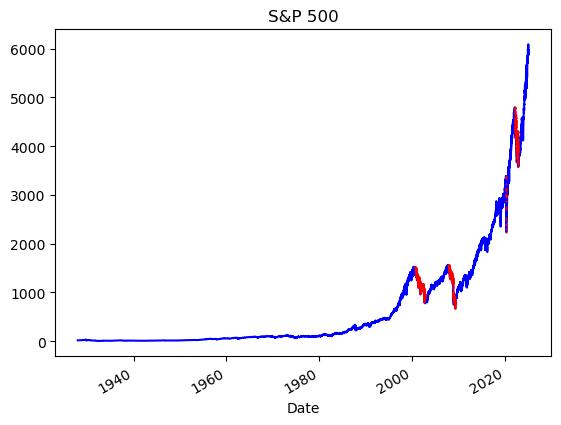

In [30]:
# Plotting the S&P 500 daily returns during bear markets
%matplotlib inline
import matplotlib.pyplot as plt
spx['Close'].plot(color='blue')
spx_bear['Close'].plot(color='red',linestyle='',marker='.',markersize=1)
plt.title(f'S&P 500')
plt.show()

In [ ]:
# Find stocks which are less affected by bear markets
import yfinance as yf
import numpy as np
import pandas as pd


stocks=['AAPL','NVDA','MSFT','GOOG','GOOGL','AMZN','META','TSLA']
spx=yf.Ticker('^GSPC').history(start=bear_markets[0][0], end=bear_markets[-1][-1])
spx['daily_return']=spx['Close'].pct_change()
spx.dropna(inplace=True)


bear_markets=[('2000-08-29','2002-09-03'),('2007-10-09','2009-03-09'),('2020-02-19','2020-03-23'),('2021-12-29','2022-10-04')]

def get_bear_market_returns(bear_markets, tikr):
    try:
        data=yf.Ticker(tikr).history(period="max")
    except:
        print(f'Ticker {tikr} not found')
        return None
    bear_returns = []
    for bear_market in bear_markets:
        start,end=bear_market
        _data=data[(data.index>=start) & (data.index<=end)]
        if _data.empty:
            continue
        bear_returns.append((_data['Close'].iloc[-1]-_data['Close'].iloc[0])/_data['Close'].iloc[0])
    
    return np.average(bear_returns)# if bear_returns else None

bear_returns = [get_bear_market_returns(bear_markets, tikr) for tikr in stocks]


['-0.44', '-0.60', '-0.34', '-0.38', '-0.38', '-0.35', '-0.45', '-0.42']


In [ ]:
df=pd.DataFrame({'stocks':tickrs,'bear_returns':bear_returns})
df.sort_values(by='bear_returns',ascending=False,inplace=True)
df.to_csv('bear_returns.csv',index=False)
df.head(20)


In [58]:
df=pd.read_csv('bear_returns.csv')
df

,stocks,bear_returns
0,CEG,1.143218
1,TSCO,0.830696
2,AZO,0.538697
3,NVR,0.516403
4,VTR,0.427086
...,...,...
505,MLIFT,NaN
506,AMTM,NaN
507,MXN,NaN
508,ESZ4,NaN


In [62]:
get_bear_market_returns(bear_markets,'NVR')

0.5164030517709728

In [55]:
print(f"SPX: {get_bear_market_returns(bear_markets, '^GSPC')*100:.2f}%")
print([f'{stock}: {x*100:.2f}%' for stock,x in zip(stocks,bear_returns)])


SPX: -38.36%
['AAPL: -43.91%', 'NVDA: -60.39%', 'MSFT: -34.02%', 'GOOG: -37.87%', 'GOOGL: -38.09%', 'AMZN: -35.11%', 'META: -45.50%', 'TSLA: -41.88%']
